<a href="https://colab.research.google.com/github/thuongvan23/XAI-LandCover/blob/nhanLD/EfficientNet_satellite_frozen_BigEarthNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/bigearthnet_12band_10m.zip" -d /content/

In [ ]:
import os

# Đường dẫn thư mục chứa ảnh đa phổ đã xử lý
data_dir = "/content/content/bigearthnet_12band_10m"

class_counts = {}
total_images = 0

for label in sorted(os.listdir(data_dir)):
    class_path = os.path.join(data_dir, label)
    if os.path.isdir(class_path):
        n_files = len([f for f in os.listdir(class_path) if f.endswith('.tif')])
        class_counts[label] = n_files
        total_images += n_files

# In kết quả
print("Số lượng ảnh mỗi class:")
for label, count in class_counts.items():
    print(f"Class {label}: {count} ảnh")

print(f"\nTổng số ảnh: {total_images}")

Số lượng ảnh mỗi class:
Class S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP: 3305 ảnh
Class S2A_MSIL2A_20170613T101031_N9999_R022_T34VER: 6686 ảnh
Class S2A_MSIL2A_20170617T113321_N9999_R080_T29UPU: 7986 ảnh
Class S2A_MSIL2A_20170701T093031_N9999_R136_T35VPK: 7997 ảnh
Class S2A_MSIL2A_20170704T112111_N9999_R037_T29SND: 8216 ảnh
Class S2A_MSIL2A_20170717T113321_N9999_R080_T29UPA: 370 ảnh
Class S2A_MSIL2A_20170717T113321_N9999_R080_T29UPV: 6013 ảnh
Class S2A_MSIL2A_20170720T100031_N9999_R122_T34UDG: 1540 ảnh
Class S2A_MSIL2A_20170803T094031_N9999_R036_T34TCR: 4864 ảnh
Class S2A_MSIL2A_20170813T112121_N9999_R037_T29SNC: 8222 ảnh

Tổng số ảnh: 55199


In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 17.5 MB/s eta 0:00:00


Shape của ảnh S2A_MSIL2A_20170803T094031_N9999_R036_T34TCR_80_05_12band.tif: (12, 120, 120) (channels, height, width)


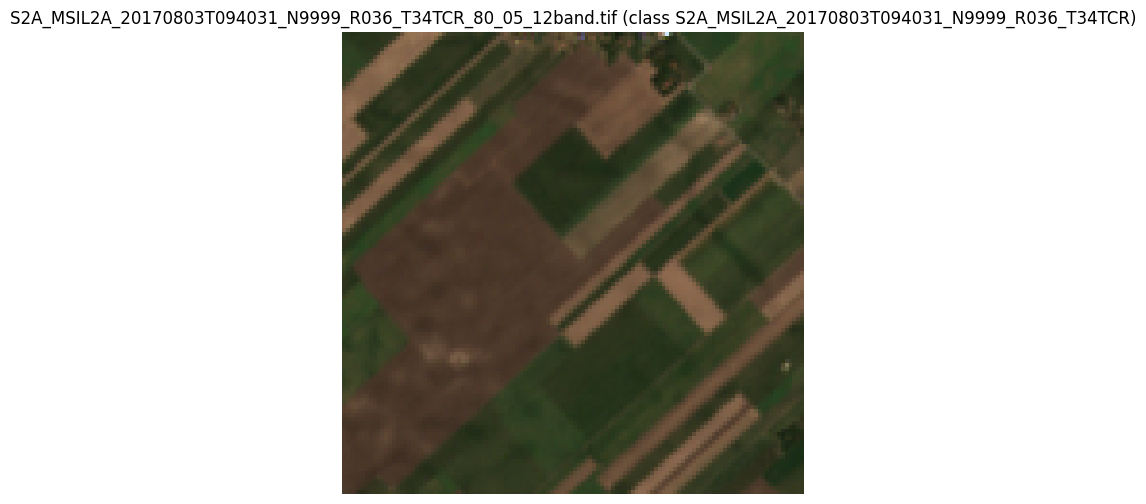

In [ ]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import random

# Chọn ngẫu nhiên 1 class và 1 ảnh trong class
random_class = random.choice(os.listdir(data_dir))
img_path = os.path.join(data_dir, random_class)
random_img = random.choice([f for f in os.listdir(img_path) if f.endswith('.tif')])
img_full_path = os.path.join(img_path, random_img)

# Đọc ảnh
with rasterio.open(img_full_path) as src:
    img = src.read()  # shape: (12, H, W)

# In shape
print(f"Shape của ảnh {random_img}: {img.shape} (channels, height, width)")

# Hiển thị ảnh (dùng band 4,3,2 tương ứng RGB)
rgb = np.stack([img[3], img[2], img[1]], axis=-1)  # Chú ý chỉ số bắt đầu từ 0
rgb = rgb.astype(np.float32)
rgb /= np.max(rgb) + 1e-6  # Chuẩn hóa để hiển thị

plt.figure(figsize=(6, 6))
plt.imshow(rgb)
plt.title(f"{random_img} (class {random_class})")
plt.axis('off')
plt.show()


In [ ]:
import os
import random
from glob import glob
from sklearn.model_selection import train_test_split

# Gốc thư mục lưu các ảnh đã xử lý (12 band)
DATA_DIR = "/content/content/bigearthnet_12band_10m"

# Thiết lập tỉ lệ chia
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Đảm bảo tái lập kết quả
random.seed(42)

# Danh sách ảnh và nhãn
train_list = []
val_list = []
test_list = []

# Duyệt qua 10 class (0-9)
for class_label in sorted(os.listdir(DATA_DIR)):
    class_dir = os.path.join(DATA_DIR, class_label)
    if not os.path.isdir(class_dir):
        continue

    # Lấy tất cả ảnh .tif trong class
    image_paths = glob(os.path.join(class_dir, "*.tif"))
    if len(image_paths) < 5:
        continue  # bỏ qua nếu ít ảnh

    # Shuffle
    random.shuffle(image_paths)

    # Chia train/val/test
    train_images, temp = train_test_split(image_paths, train_size=train_ratio, random_state=42)
    val_images, test_images = train_test_split(temp, test_size=test_ratio / (val_ratio + test_ratio), random_state=42)

    # Gán nhãn
    # Nếu bạn chỉ cần giữ nhãn là tên folder (chuỗi)
    train_list.extend([(path, class_label) for path in train_images])
    val_list.extend([(path, class_label) for path in val_images])
    test_list.extend([(path, class_label) for path in test_images])


print(f"Số ảnh train: {len(train_list)}")
print(f"Số ảnh val: {len(val_list)}")
print(f"Số ảnh test: {len(test_list)}")


Số ảnh train: 38636
Số ảnh val: 8280
Số ảnh test: 8283


In [ ]:
!pip install albumentations

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    # A.Normalize(mean=[0]*12, std=[1]*12, max_pixel_value=1.0),

    # A.Resize(244, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.Normalize(mean=0.0, std=1.0, max_pixel_value=1.0),
    ToTensorV2(transpose_mask=True),
])

val_transform = A.Compose([
    # A.Resize(224, 224),
    A.Normalize(mean=[0]*12, std=[1]*12, max_pixel_value=1.0),
    ToTensorV2(transpose_mask=False)
])


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
from torch.utils.data import Dataset
import torch
import tifffile as tiff

class BigEarthNetDataset(Dataset):
    def __init__(self, data_list, transform=None, label2index=None):
        self.data_list = data_list
        self.transform = transform
        self.label2index = label2index

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        img_path, label = self.data_list[idx]

        with rasterio.open(img_path) as src:
            image = src.read()  # (12, H, W)

        image = image.astype(np.float32) / 10000.0
        image = np.transpose(image, (1, 2, 0))  # (H, W, C)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        else:
            image = torch.tensor(np.transpose(image, (2, 0, 1)))

        label_idx = self.label2index[label]
        return image, label_idx

In [ ]:
from torch.utils.data import DataLoader

# Batch size
BATCH_SIZE = 16

# Tạo ánh xạ label <-> index
label_set = sorted(set([label for _, label in train_list + val_list + test_list]))
label2index = {label: idx for idx, label in enumerate(label_set)}
index2label = {idx: label for label, idx in label2index.items()}
NUM_CLASSES = len(label2index)

# Dataset
train_dataset = BigEarthNetDataset(train_list, transform=train_transform, label2index=label2index)
val_dataset = BigEarthNetDataset(val_list, transform=val_transform, label2index=label2index)
test_dataset = BigEarthNetDataset(test_list, transform=val_transform, label2index=label2index)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

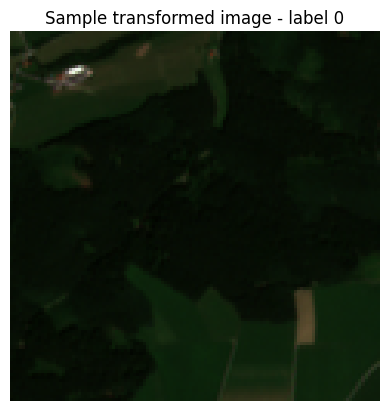

In [ ]:
# Lấy 1 mẫu bất kỳ từ train_dataset
sample_img, sample_label = train_dataset[0]

# Chuyển tensor về numpy để hiển thị
sample_img_np = sample_img.numpy().transpose(1, 2, 0)  # (H, W, C)

# Lấy lại các band RGB (band 4, 3, 2 --> index 3, 2, 1)
rgb = sample_img_np[:, :, [3, 2, 1]]

# Chuẩn hóa về [0, 1] nếu cần (nếu bạn đã normalize thì giá trị có thể lệch)
rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-6)

import matplotlib.pyplot as plt
plt.imshow(rgb)
plt.title(f"Sample transformed image - label {sample_label}")
plt.axis("off")
plt.show()


In [ ]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.0 MB/s eta 0:00:00
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=a379becf685865ed2af2f2a1287cc93dc513a0fbcb8d5dd26

In [ ]:
# 1. Import cần thiết
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from efficientnet_pytorch import EfficientNet

In [ ]:
# 2. Hàm tạo mô hình EfficientNet cho 12 band

class EfficientNetSatelliteFrozen(nn.Module):
    def __init__(self, num_classes=10):
        super(EfficientNetSatelliteFrozen, self).__init__()
        # Load EfficientNet-b0 từ đầu (không pretrained)
        self.backbone = EfficientNet.from_name('efficientnet-b0')

        # Thay đổi layer đầu vào để nhận 12 kênh
        out_channels = self.backbone._conv_stem.out_channels
        self.backbone._conv_stem = nn.Conv2d(12, out_channels, kernel_size=3, stride=2, padding=1, bias=False)

        # Đóng băng toàn bộ backbone
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Giữ lại phần classification head (chỉ phần này sẽ học)
        in_features = self.backbone._fc.in_features
        self.backbone._fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

In [ ]:
# 3. EarlyStopping
class EarlyStopping:
    def __init__(self, patience=7, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
# 4. Vòng lặp train/eval
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
    return total_loss / total, correct / total

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
    return total_loss / total, correct / total

In [ ]:
#5. TRAINING THE MODEL
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetSatelliteFrozen(num_classes=NUM_CLASSES).to(device)

# Chỉ train phần classification head (_fc)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=50):
    early_stopping = EarlyStopping(patience=5, delta=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        scheduler.step(val_loss)
        early_stopping(val_loss)

        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
        print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")

        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=50)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50:
  Train Loss: 1.9594 | Train Acc: 0.2747
  Val   Loss: 2.0343 | Val   Acc: 0.3464
  LR: 0.001000
Epoch 2/50:
  Train Loss: 1.9327 | Train Acc: 0.2900
  Val   Loss: 1.9886 | Val   Acc: 0.3092
  LR: 0.001000
Epoch 3/50:
  Train Loss: 1.9230 | Train Acc: 0.2979
  Val   Loss: 1.9650 | Val   Acc: 0.3198
  LR: 0.001000
Epoch 4/50:
  Train Loss: 1.9200 | Train Acc: 0.2940
  Val   Loss: 1.9820 | Val   Acc: 0.2903
  LR: 0.001000
Epoch 5/50:
  Train Loss: 1.9219 | Train Acc: 0.3009
  Val   Loss: 2.0480 | Val   Acc: 0.3417
  LR: 0.001000
Epoch 6/50:
  Train Loss: 1.9238 | Train Acc: 0.2951
  Val   Loss: 1.9629 | Val   Acc: 0.3161
  LR: 0.001000
Epoch 7/50:
  Train Loss: 1.9245 | Train Acc: 0.2978
  Val   Loss: 1.9403 | Val   Acc: 0.3246
  LR: 0.001000
Epoch 8/50:
  Train Loss: 1.9158 | Train Acc: 0.2988
  Val   Loss: 1.9632 | Val   Acc: 0.3337
  LR: 0.001000
Epoch 9/50:
  Train Loss: 1.9208 | Train Acc: 0.2974
  Val   Loss: 1.9351 | Val   Acc: 0.3309
  LR: 0.001000
Epoch 10/50:
  Trai

In [ ]:
#6. Đánh giá trên tập test
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")


Test Loss: 2.0227 | Test Acc: 0.3110


In [ ]:
torch.save(model, "/content/drive/MyDrive/Efficientnet_satellite_frozen_BigEarthNet.pth")